In [100]:
import sys
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# import local modules
sys.path.append('../src')
from Fishnet import Fishnet
from ImageExporter import ImageExporter
from ImageCorrector import ImageCorrector
from ImageProcessor import ImageProcessor

# update files automatically
%load_ext autoreload
%autoreload 2

## Install package within conda using tensorflow
## /opt/homebrew/Caskroom/miniconda/base/envs/capstone_2/bin/pip install tensorflow

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.random.set_seed(42)

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox
import datetime

In [4]:
fc = Fishnet.load("../Gis/Fishnet/fishnet_quarter_mile_completed.pkl")

In [101]:
# Compute Urbanization Rate
# for year in [2017, 2018, 2019, 2020, 2021, 2022]:
#     fc.compute_difference(f'MeanPixel_{year}', f'MeanPixel_{year-1}', filtered=True, normalize = True)

vars = ["id", "batch_id", "MeanPixel_2016", "MeanPixel_2017", "MeanPixel_2018", "MeanPixel_2019", "MeanPixel_2020", "MeanPixel_2021", "MeanPixel_2022"]
data = fc.filtered_fishnet[vars]
data.rename(columns={"id": "tile_id"}, inplace=True)
data["tile_id"] = data["tile_id"].astype(int)
data["batch_id"] = data["batch_id"].astype(int)    

# Pivot wide to long
data = data.melt(id_vars=["tile_id", "batch_id"], var_name="year", value_name="urbanization")
data["urbanization"] = data["urbanization"] / 255 #normalization
data["year"] = data["year"].str[-4:]
data.head()



# data.to_csv('../Results/urbanization.csv', index=False)

,tile_id,batch_id,year,urbanization
0,6060154,23743,2016,0.710556
1,6060155,23743,2016,0.802841
2,6060156,23743,2016,0.550000
3,6060157,23743,2016,0.447222
4,6060158,23743,2016,0.773333


In [6]:
#compute rows and cols in Fishnet
dc = fc.filtered_fishnet.copy()
L = dc["geometry"].bounds["maxx"].max() - dc["geometry"].bounds["minx"].min()
H = dc["geometry"].bounds["maxy"].max() - dc["geometry"].bounds["miny"].min()

rows = int(H / fc.tile_height_degrees)
cols = int(L / fc.tile_width_degrees)
print(f"Number of rows: {rows}, Number of columns: {cols}")

Number of rows: 117, Number of columns: 193


In [7]:
# Generate tensor
years = ["2016", "2017", "2018", "2019", "2020", "2021", "2022"]
tensor = np.zeros((len(years), rows, cols, 1))

for yr in tqdm(years):
    tensor[years.index(yr), :, :, 0] = data[data["year"]== yr]["urbanization"].to_numpy().reshape(rows, cols)

100%|██████████| 7/7 [00:00<00:00, 155.06it/s]


In [8]:
tensor.shape

(7, 117, 193, 1)

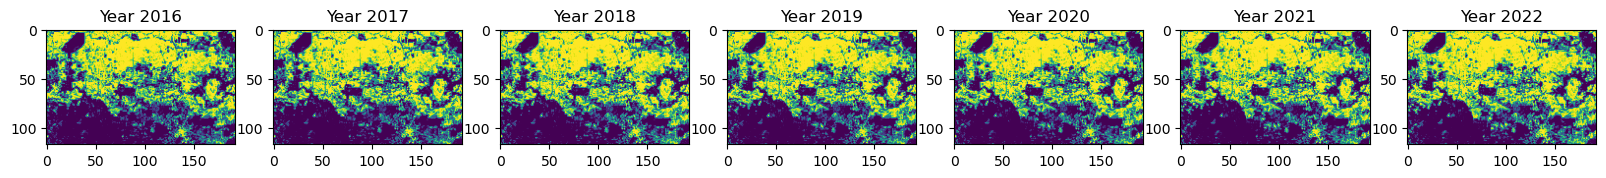

In [9]:
# plot consecutively to see the change
fig, ax = plt.subplots(1, 7, figsize=(20, 5))
for i in range(7):
    ax[i].imshow(tensor[i, :, :, 0])
    ax[i].set_title(f"Year {years[i]}")

# Now, we need to generate the dataset.

We need a data loader. We need to generate a dataset of that dimension:
(NBR_SAMPLE, TIME_SEQ, IMG_WIDTH, IMG_HEIGHT, CHANNELS)

@TODO:

1. Define proper loss function for the neural network (MSE)
2. Check which frames are used for training
3. ✅ Add TensorBoard
3.5. Add TensorBoard on Colab
4. Brainstorm the architecture
5. ✅ Start training from a pre-trained network
6. Compare frequence of de-urbanization to urbanization
7. Try to apply the video prediction framework on the urbanization RATE (not on urbanization to have an easier metric)
8. Create an artificial dataset to see how the model evolve
9. Export a bigger dataset (whole Texas Region)

In [10]:
def extract_submatrix(matrix, length, slide_size):
    submatrices = []
    rows, cols = matrix.shape
    for i in range(0, rows - (length - 1), slide_size):
        for j in range(0, cols - (length - 1), slide_size):
            submatrix = matrix[i:i+length, j:j+length]
            submatrices.append(submatrix)
    return np.array(submatrices)

def generate_submatrices(tensor, years, length, slide_size):
    submatrices = []
    for i, yr in enumerate(years):
        mat = tensor[i, :, :, 0]
        submatrices.append(extract_submatrix(mat, length, slide_size))
    submatrices = np.array(submatrices)
    print(np.array(submatrices).shape)
    transposed_array = np.transpose(submatrices, (1, 0, 2, 3))
    reshaped_array = transposed_array.reshape((-1, 7, length, length, 1))
    return reshaped_array

In [11]:
TIME_SEQ = 7  # frames
IMG_SIZE = 15  # tiles
SLIDE_WDW = 5 # tiles

sub_matrices = generate_submatrices(tensor, years, IMG_SIZE, SLIDE_WDW)
sub_matrices.shape

(7, 756, 15, 15)


(756, 7, 15, 15, 1)

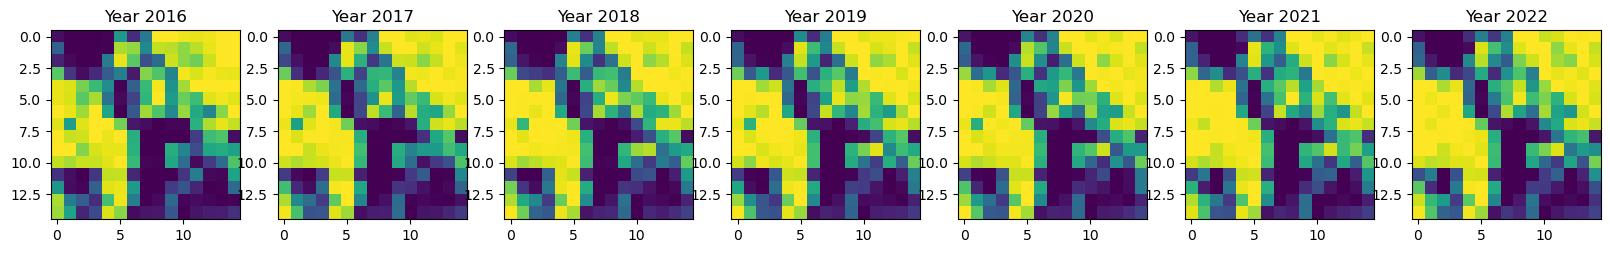

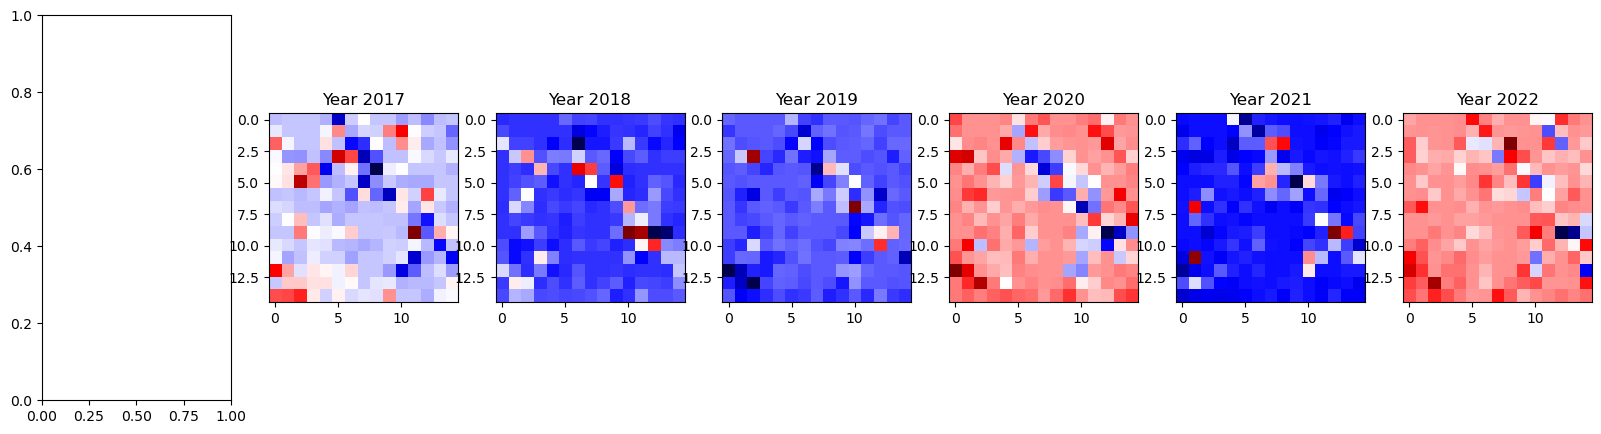

In [12]:
k = np.random.choice(range(len(sub_matrices)), size=1)[0]

# plot all these images on 7 plots
fig, ax = plt.subplots(1, 7, figsize=(20, 5))
for i in range(7):
    ax[i].imshow(sub_matrices[k][i, :, :, 0])
    ax[i].set_title(f"Year {years[i]}")

# plot all these images on 7 plots
fig, ax = plt.subplots(1, 7, figsize=(20, 5))
for i in range(1, 7):
    ax[i].imshow(sub_matrices[k][i, :, :, 0] - sub_matrices[k][i-1, :, :, 0], cmap='seismic')
    ax[i].set_title(f"Year {years[i]}")


# Applying Keras' Tutorial Function to finish dataset generation

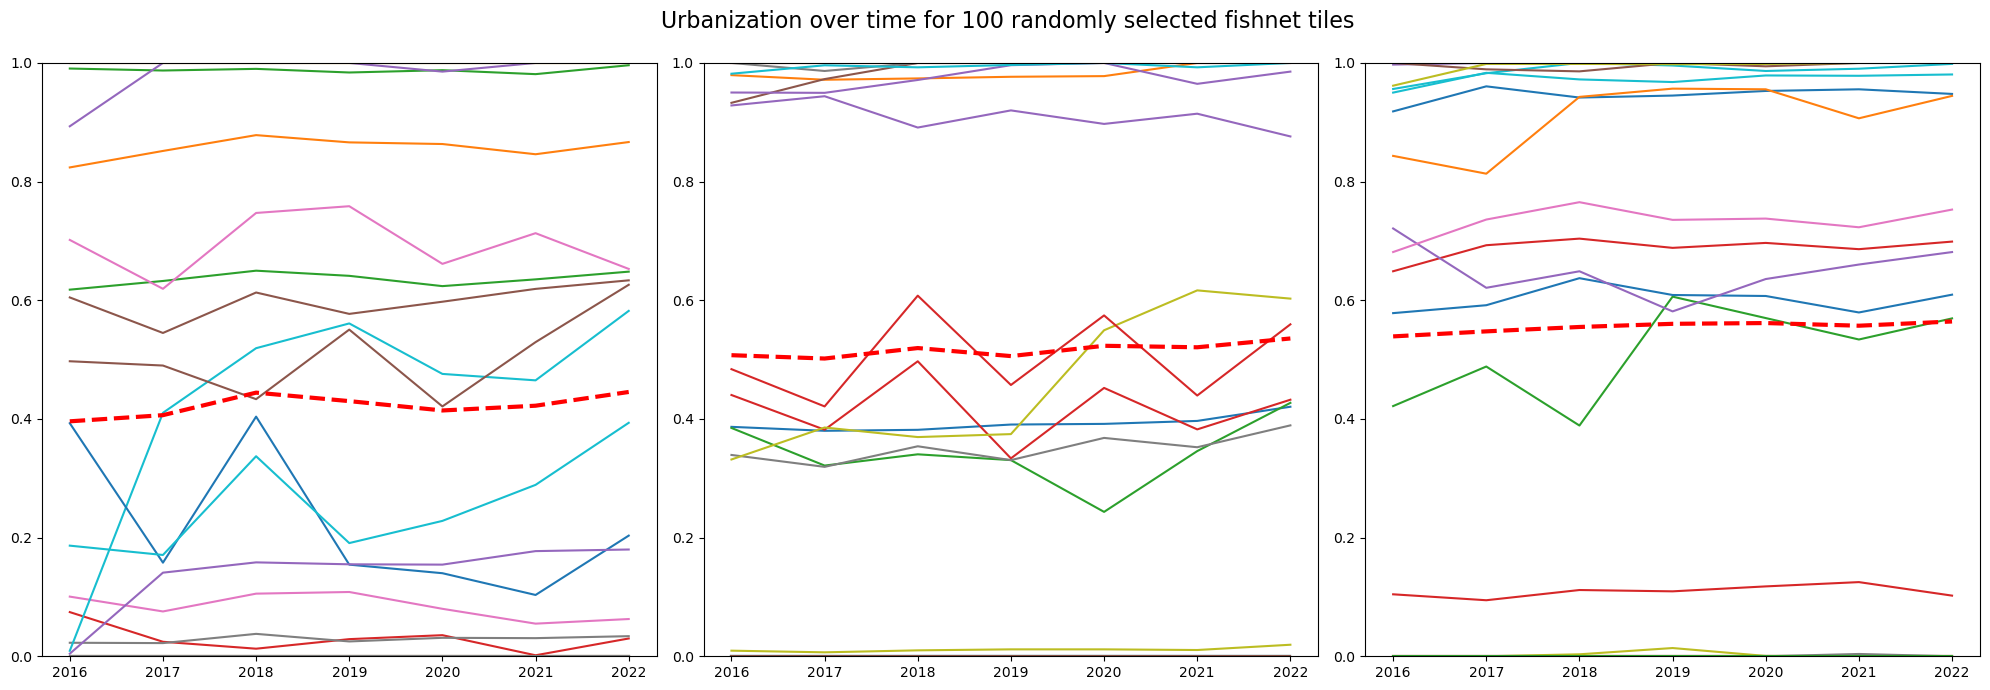

In [13]:
# Plot the yearly urbanization for 100 different tile_ids randomly selected
fig, ax = plt.subplots(1, 3, figsize=(20, 7))
for subplot in ax:
    for _ in range(20):
        tile_id = np.random.choice(data["tile_id"].unique())
        subplot.plot(data[data["tile_id"]==tile_id]["year"], data[data["tile_id"]==tile_id]["urbanization"])
        subplot.set_ylim([0, 1])
        # subplot.set_xticks([])
        # subplot.set_yticks([])
        # subplot.legend([])

    # title for the whole
    ax[1].set_title("Urbanization over time for 100 randomly selected fishnet tiles \n", fontsize=16, loc="center")

    # Calculate and plot the average line
    avg_line = np.mean([line.get_ydata() for line in subplot.lines], axis=0)
    subplot.plot(data[data["tile_id"]==tile_id]["year"], avg_line, color="red", linestyle="--", label="Average", linewidth=3)

# plt.title("Urbanization over time for 100 randomly selected fishnet tiles", fontsize=16, loc="left")
plt.tight_layout()
plt.show()


Displaying frames for example 24.


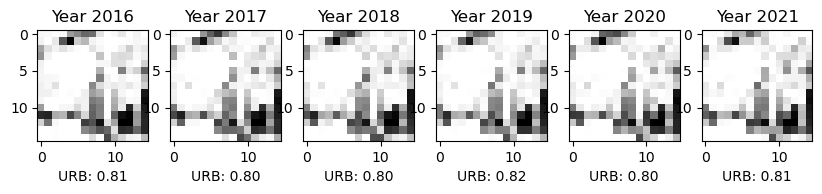

In [14]:
dataset = sub_matrices

# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(1, 6, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Year {years[idx]}")
    # ax.axis("off")
    ax.set_xlabel(f"URB: {np.mean(dataset[data_choice][idx]):.2f}")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

# Generate the training dataset

In [15]:
dataset = sub_matrices
train_dataset = dataset[:, 0:6, :, :, :]

# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def generate_shited_frames(data, type):
    shape = data.shape
    if type == "train":
        x_1 = data[:, 0 : 4, :, :]
        y_1 = data[:, 4, :, :]
        x_2 = data[:, 1 : 5, :, :]
        y_2 = data[:, 5, :, :]
        x = np.concatenate((x_1, x_2))
        y = np.concatenate((y_1, y_2)).reshape((data.shape[0]*2,1, data.shape[2], data.shape[3], data.shape[4]))
    elif type == "validation":
        x = data[:, 2 : 6, :, :]
        y = data[:, 6, :, :].reshape(data.shape[0],1, data.shape[2], data.shape[3], data.shape[4])
    else:
        raise ValueError("Type must be train or validation")
    return x, y

# Apply the processing function to the datasets.
x_train, y_train = generate_shited_frames(dataset, "train")
x_val, y_val = generate_shited_frames(dataset, "validation")

# Create a Keras input dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (1512, 4, 15, 15, 1), (1512, 1, 15, 15, 1)
Validation Dataset Shapes: (756, 4, 15, 15, 1), (756, 1, 15, 15, 1)


In [16]:
# How to get one pair (X,y) ? 
train_iter = iter(train_dataset)
x, y = next(train_iter)
print(x.shape)
print(y.shape)

(4, 15, 15, 1)
(1, 15, 15, 1)


# Data Augmentation

We will apply the following data augmentation to increase the size of our dataset.

1. Rotation (90, 180 and 270 degrees)

2. Vertical and Horizontal Symmetries

In [17]:
def rotate_image(image, k):
    return tf.image.rot90(image, k)

def augment(x, y):
    # Random rotation between -90 and 180 degrees
    k = np.random.choice([-1, 0, 1, 2])
    x_aug = tf.map_fn(lambda image: rotate_image(image, k), x)
    y_aug = tf.map_fn(lambda image: rotate_image(image, k), y)

    # Horizontal flip
    l = np.random.choice([0, 1])
    if l == 0:
        x_aug = tf.image.flip_left_right(x_aug)
        y_aug = tf.image.flip_left_right(y_aug)

    # Vertical flip
    m = np.random.choice([0, 1])
    if m == 0:
        x_aug = tf.image.flip_up_down(x_aug)
        y_aug = tf.image.flip_up_down(y_aug)

    return x_aug, y_aug


In [18]:
train_iter = iter(train_dataset)
X, y = next(train_iter)
X_aug, y_aug = augment(X, y) 

In [19]:
AUTOTUNE = tf.data.AUTOTUNE
aug_train_dataset = train_dataset.map(lambda x, y: (augment(x, y)), 
                num_parallel_calls=AUTOTUNE)

# Visualize the data augmentation

In [20]:
def plot_seq(x,y):
    fig, axes = plt.subplots(1, 5, figsize=(10, 4))
    for i in range(4):
        axes[i].imshow(x[i, :, :, 0], cmap='gray')
    axes[4].imshow(y[0, :, :, 0], cmap='gray')
    plt.tight_layout()

def plot_seq_aug(x, y, x_aug, y_aug):
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i in range(4):
        axes[0, i].imshow(x[i, :, :, 0], cmap='gray')
        axes[1, i].imshow(x_aug[i, :, :, 0], cmap='gray')

    axes[0, 4].imshow(y[0, :, :, 0], cmap='gray')
    axes[1, 4].imshow(y_aug[0, :, :, 0], cmap='gray')
    
    # add titles to each subrow
    axes[0, 2].set_title('Original')
    axes[1, 2].set_title('Augmented')
    plt.tight_layout()


In [21]:
train_iter = iter(train_dataset)
aug_train_iter = iter(aug_train_dataset)

2023-07-17 09:48:20.351389: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


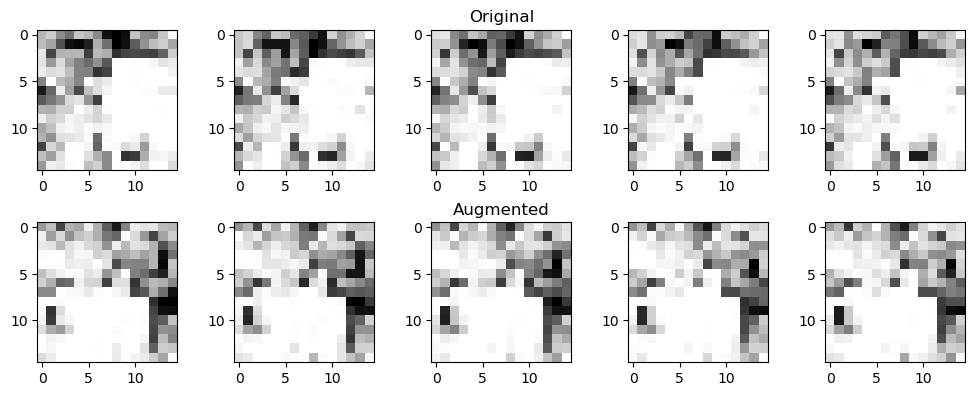

In [22]:
# get a random element from train_dataset
x, y = next(train_iter)
x_aug, y_aug = next(aug_train_iter)

plot_seq_aug(x, y, x_aug, y_aug)

# Training the model

## Prepare the data

In [758]:
def prepare(ds, batch_size, shuffle=False, augment=None):

    # Augment data
    if shuffle:
        ds = ds.shuffle(1000)

    # Apply mapping function
    if augment is not None:
        # ds_aug = ds.map(lambda x, y: augment(x, y), 
        #         num_parallel_calls=AUTOTUNE)
        ds_aug = ds.map(augment, num_parallel_calls=AUTOTUNE)
        ds = ds.concatenate(ds_aug)

    # Batch all datasets.
    ds = ds.batch(batch_size)

    return ds.prefetch(buffer_size=AUTOTUNE)

In [802]:
len(train_dataset)

1512

In [804]:
len(train_ds)*32

3040

In [759]:
batch_size = 32

train_ds = prepare(train_dataset, batch_size, shuffle=True, augment=augment)
val_ds = prepare(val_dataset, batch_size)

In [761]:
def create_model():
    # Construct the input layer with 4 time frames in input
    inp = layers.Input(shape=(4, *x_train.shape[2:]))

    # We will construct 3 `ConvLSTM2D` layers with batch normalization,
    # followed by a `Conv3D` layer for the spatiotemporal outputs.
    x = layers.ConvLSTM2D(
        filters=64,                # transform each image into a 64 channel image 
        kernel_size=(3, 3),        # each image [7,7] --> [5,5] (with 64 channels, see above, filters)
        padding="same",           # valid: no padding (so image stays [5,5], same: padding so image stays [6x6])
        return_sequences=True,
        activation="relu",
    )(inp)
    x = layers.BatchNormalization()(x)   # improve the training speed, stability, and generalization of the network
    x = layers.ConvLSTM2D(
        filters=64,                      # 
        kernel_size=(3, 3),              # each previous [5,5] image --> [3,3] image
        padding="same",
        return_sequences=True,
        activation="relu",
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.ConvLSTM2D(
        filters=64,
        kernel_size=(1, 1),
        padding="same",
        return_sequences=False,
        activation="relu",
    )(x)
    x = layers.Conv2D(
        filters=1,               # 1 filter leads to one chanel in the output
        kernel_size=(3, 3),   # 
        activation="sigmoid", 
        padding="same"
    )(x)

    # Next, we will build the complete model and compile it.
    model = keras.models.Model(inp, x)
    model.compile(optimizer="adam", loss=tf.keras.losses.MeanSquaredError())
    return model

# Train the model from scratch
model = create_model()

# Use a pretrained model from HuggingFace (https://huggingface.co/keras-io/conv-lstm)
# model_path = "./pretrained-models/"
# model = tf.keras.models.load_model(model_path)

In [762]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


# Training the model

In [806]:
# Set tensorboard Callback
log_dir = "./logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 200

# Fit the model to the training data.
model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[tensorboard_callback],#early_stopping, reduce_lr],
)

Epoch 1/200
95/95 [==============================] - 33s 312ms/step - loss: 0.0741 - val_loss: 0.0933
Epoch 2/200
95/95 [==============================] - 29s 305ms/step - loss: 0.0785 - val_loss: 0.0817
Epoch 3/200
95/95 [==============================] - 29s 309ms/step - loss: 0.0755 - val_loss: 0.0804
Epoch 4/200
95/95 [==============================] - 29s 302ms/step - loss: 0.0734 - val_loss: 0.0791
Epoch 5/200
95/95 [==============================] - 30s 319ms/step - loss: 0.0724 - val_loss: 0.0769
Epoch 6/200
95/95 [==============================] - 30s 313ms/step - loss: 0.0712 - val_loss: 0.0850
Epoch 7/200
95/95 [==============================] - 31s 328ms/step - loss: 0.0705 - val_loss: 0.0757
Epoch 8/200
95/95 [==============================] - 30s 314ms/step - loss: 0.0696 - val_loss: 0.0769
Epoch 9/200
95/95 [==============================] - 30s 316ms/step - loss: 0.0691 - val_loss: 0.0759
Epoch 10/200
95/95 [==============================] - 28s 299ms/step - loss: 0.068

KeyboardInterrupt: 

# Tensorboard

In [ ]:
# Clear any logs from previous runs
# %rm -rf ./logs/

In [764]:
# command to kill tensorboard process on port 6006: kill $(ps -e | grep 'tensorboard' | awk '{print $1}')
# Run TensorBoard
%reload_ext tensorboard
%tensorboard --logdir=logs

Reusing TensorBoard on port 6006 (pid 44957), started 2 days, 2:31:36 ago. (Use '!kill 44957' to kill it.)

# Analyze the results

Let's work on one tile. Let's assume that we predict the next urbanization rate of that specific tile.

1. Compute total R2 for that prediction ?

In [65]:
# predict the values of the test set using keras
y_pred = model.predict(x_val)

ValueError: in user code:

    File "/opt/homebrew/Caskroom/miniconda/base/envs/capstone_2/lib/python3.11/site-packages/keras/engine/training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniconda/base/envs/capstone_2/lib/python3.11/site-packages/keras/engine/training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniconda/base/envs/capstone_2/lib/python3.11/site-packages/keras/engine/training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "/opt/homebrew/Caskroom/miniconda/base/envs/capstone_2/lib/python3.11/site-packages/keras/engine/training.py", line 2111, in predict_step
        return self(x, training=False)
    File "/opt/homebrew/Caskroom/miniconda/base/envs/capstone_2/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/homebrew/Caskroom/miniconda/base/envs/capstone_2/lib/python3.11/site-packages/keras/engine/input_spec.py", line 235, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_6' (type Sequential).
    
    Input 0 of layer "lstm_7" is incompatible with the layer: expected ndim=3, found ndim=5. Full shape received: (None, 4, 15, 15, 1)
    
    Call arguments received by layer 'sequential_6' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 4, 15, 15, 1), dtype=float32)
      • training=False
      • mask=None


In [808]:
# flatten the y tensors
y_pred_flat = y_pred.flatten()
y_val_flat = y_val.flatten()

# compute the R^2
from sklearn.metrics import r2_score

r2_score(y_val_flat, y_pred_flat)

0.372313263201565

# Baseline Model

Let's define two baseline models here: 

1. Taking the average of urbanization over the last 4 years to predict the fifth one.
2. Using an XGBoost to predict the 5th one based on the 4 previous years. 


### `Baseline 1`


#### URBANIZATION

In [66]:
# Test set
x_test = tensor[2:6, :, :, 0]
y_test = tensor[6, :, :, 0]

# mean of the last 4 years
y_pred_baseline = np.mean(x_test, axis=0)

# %%
# compute mse and r2 with scikitlearn
from sklearn.metrics import mean_squared_error, r2_score

mse_baseline = mean_squared_error(y_test, y_pred_baseline)
r2_baseline = r2_score(y_test, y_pred_baseline)

print(f"Baseline MSE: {mse_baseline}")
print(f"Baseline R2: {r2_baseline}")

Baseline MSE: 0.005912100328010498
Baseline R2: 0.96028700772427


#### URBANIZATION RATE

In [99]:
# Test set
x_test = tensor[2:6, :, :, 0] - tensor[1:5, :, :, 0]
y_test = tensor[6, :, :, 0] - tensor[5, :, :, 0]

# mean of the last 4 years
y_pred_baseline = np.mean(x_test, axis=0)

# set negative values to 0
y_pred_baseline[y_pred_baseline < 0] = 0
y_test[y_test < 0] = 0

# %%
# compute mse and r2 with scikitlearn
from sklearn.metrics import mean_squared_error, r2_score

mse_baseline = mean_squared_error(y_test, y_pred_baseline)
r2_baseline = r2_score(y_test, y_pred_baseline)

print(f"Baseline MSE: {mse_baseline}")
print(f"Baseline R2: {r2_baseline}")

Baseline MSE: 0.002855942525584417
Baseline R2: -0.2421209937368897


### `Baseline 2`

Let's train an XGBoost Model using the same data and analyze the results that we obtain.

#### URBANIZATION

In [75]:
x_train_1 = tensor[0:4, :, :, 0].reshape(4,-1)
y_train_1 = tensor[4, :, :, 0].reshape(-1)
x_train_2 = tensor[1:5, :, :, 0].reshape(4,-1)
y_train_2 = tensor[5, :, :, 0].reshape(-1)
x_train = np.concatenate((x_train_1, x_train_2), axis=1).transpose()
y_train = np.concatenate((y_train_1, y_train_2), axis=0)

x_test = tensor[2:6, :, :, 0].reshape(4,-1).transpose()
y_test = tensor[6, :, :, 0].reshape(-1)

In [76]:
# Train an XGBoost model
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Instantiate the XGBRegressor: xg_reg
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=10, seed=42)

# Fit the regressor to the training set
xg_reg.fit(x_train, y_train)

# Predict the labels of the test set: preds
preds = xg_reg.predict(x_test)

# Compute the rmse: rmse
rmse = np.sqrt(mean_squared_error(y_test, preds))

# Print rmse
print("RMSE: %f" % (rmse))

# MSE
mse_baseline = mean_squared_error(y_test, preds)
print(f"Baseline MSE: {mse_baseline}")

# compute the R^2
from sklearn.metrics import r2_score

r2_score(y_test, preds)
print(f"Baseline R2: {r2_score(y_test, preds)}")

# compute TSS and RSS
TSS = np.sum((y_test - np.mean(y_test))**2)
RSS = np.sum((y_test - preds)**2)
print(f"TSS: {TSS}")
print(f"RSS: {RSS}")
print(f"R2: {1 - RSS/TSS}")

RMSE: 0.055752
Baseline MSE: 0.003108281234879888
Baseline R2: 0.9810506807933904
TSS: 3703.9905127747807
RSS: 70.18809856482275
R2: 0.9810506807933904


### URBANIZATION RATE

In [96]:
x_train_1 = tensor[0:4, :, :, 0].reshape(4,-1)
y_train_1 = tensor[4, :, :, 0].reshape(-1) - tensor[3, :, :, 0].reshape(-1)
x_train_2 = tensor[1:5, :, :, 0].reshape(4,-1)
y_train_2 = tensor[5, :, :, 0].reshape(-1) - tensor[4, :, :, 0].reshape(-1)
x_train = np.concatenate((x_train_1, x_train_2), axis=1).transpose()
y_train = np.concatenate((y_train_1, y_train_2), axis=0)

x_test = tensor[2:6, :, :, 0].reshape(4,-1).transpose()
y_test = tensor[6, :, :, 0].reshape(-1) - tensor[5, :, :, 0].reshape(-1)

# set negative values to 0
y_train[y_train < 0] = 0
y_test[y_test < 0] = 0

In [97]:
# Train an XGBoost model
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Instantiate the XGBRegressor: xg_reg
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=10, seed=42)

# Fit the regressor to the training set
xg_reg.fit(x_train, y_train)

# Predict the labels of the test set: preds
preds = xg_reg.predict(x_test)

# Compute the rmse: rmse
rmse = np.sqrt(mean_squared_error(y_test, preds))

# Print rmse
print("RMSE: %f" % (rmse))

# MSE
mse_baseline = mean_squared_error(y_test, preds)
print(f"Baseline MSE: {mse_baseline}")

# compute the R^2
from sklearn.metrics import r2_score

r2_score(y_test, preds)
print(f"Baseline R2: {r2_score(y_test, preds)}")

# compute TSS and RSS
TSS = np.sum((y_test - np.mean(y_test))**2)
RSS = np.sum((y_test - preds)**2)
print(f"\n TSS: {TSS}")
print(f"RSS: {RSS}")
print(f"R2: {1 - RSS/TSS}")

RMSE: 0.045984
Baseline MSE: 0.00211449796088774
Baseline R2: 0.1588245384963184

 TSS: 56.76280471787999
RSS: 47.74747845480606
R2: 0.1588245384963184


In [89]:
data.head()

,tile_id,batch_id,year,urbanization
0,6060154,23743,2016,0.710556
1,6060155,23743,2016,0.802841
2,6060156,23743,2016,0.550000
3,6060157,23743,2016,0.447222
4,6060158,23743,2016,0.773333


(array([44951.,  5266.,  4379.,  3834.,  3576.,  3484.,  3291.,  3235.,
         3334.,  3452.,  3474.,  3638.,  3815.,  4071.,  4462.,  5018.,
         5649.,  6269.,  7788., 35081.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

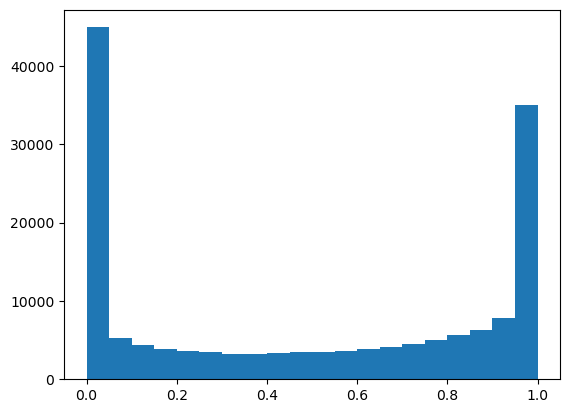

In [91]:
# histogram of urbanization
plt.hist(data["urbanization"], bins=20)

In [87]:
dcc.head()

year,2016,2017,2018,2019,2020,2021,2022,urbanization_rate_2017,urbanization_rate_2018,urbanization_rate_2019,urbanization_rate_2020,urbanization_rate_2021,urbanization_rate_2022
tile_id,,,,,,,,,,,,,
6060154,0.710556,0.773889,0.871667,0.861111,0.886111,0.913889,0.929444,0.063333,0.097778,-0.010556,0.025000,0.027778,0.015556
6060155,0.802841,0.836364,0.899432,0.896023,0.905682,0.931818,0.948295,0.033523,0.063068,-0.003409,0.009659,0.026136,0.016477
6060156,0.550000,0.521667,0.536111,0.577778,0.583333,0.661111,0.661111,-0.028333,0.014444,0.041667,0.005556,0.077778,0.000000
6060157,0.447222,0.394444,0.448889,0.806667,0.877778,0.840000,0.852778,-0.052778,0.054444,0.357778,0.071111,-0.037778,0.012778
6060158,0.773333,0.780000,0.766111,0.827222,0.831667,0.768889,0.810000,0.006667,-0.013889,0.061111,0.004444,-0.062778,0.041111


<Axes: xlabel='year', ylabel='year'>

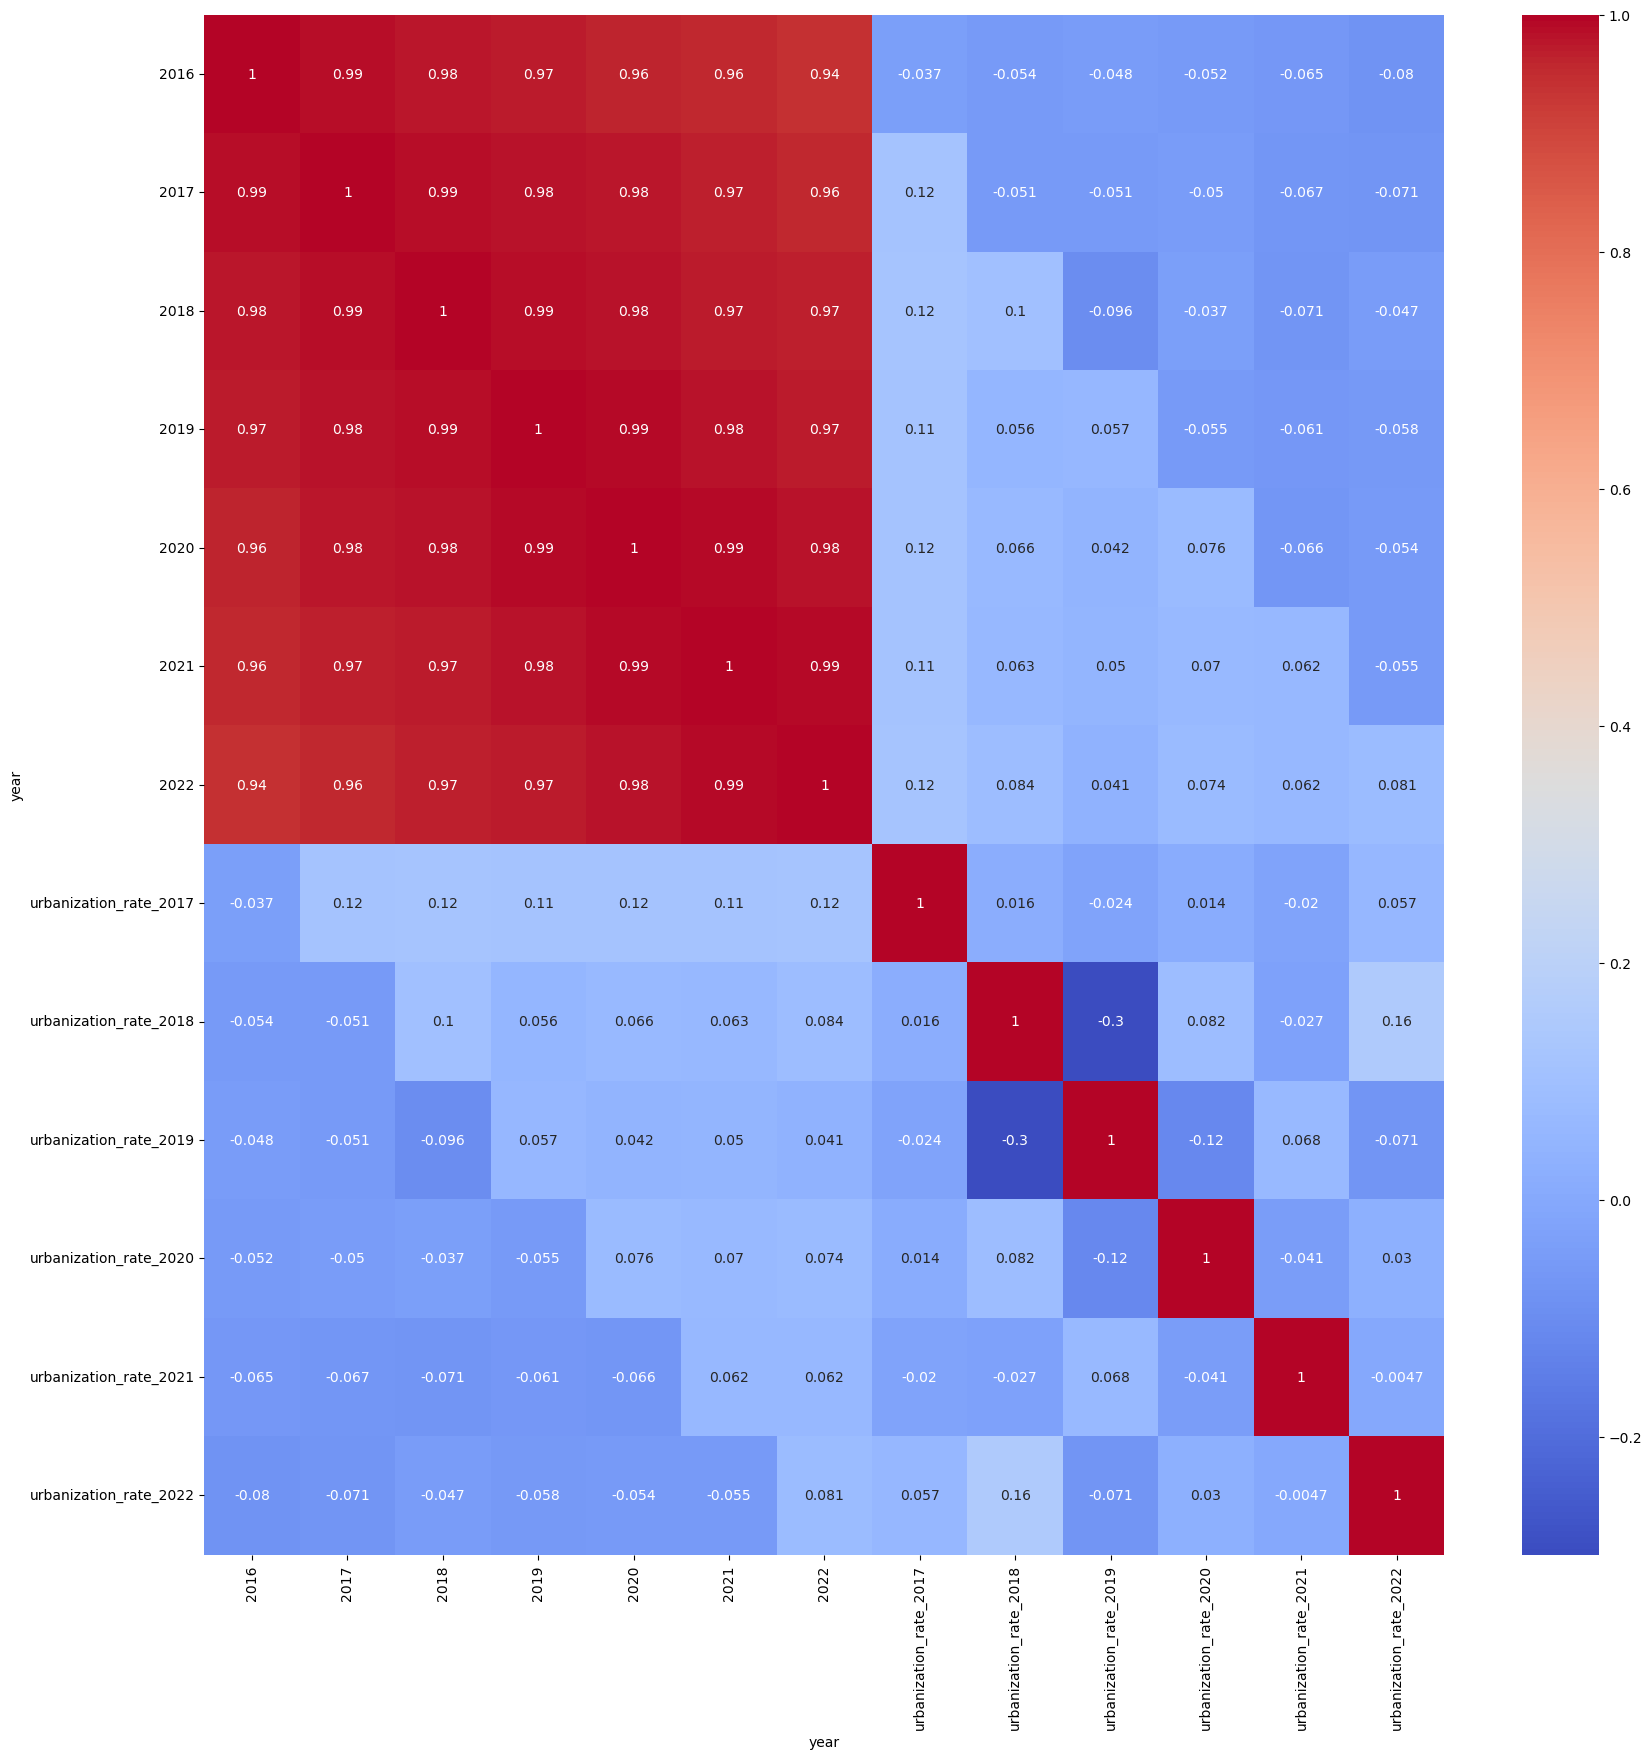

In [110]:
# pivot wide to long on year
dcc = data.pivot(index="tile_id", columns="year", values="urbanization")

# compute urbanization rate
for year in [2017, 2018, 2019, 2020, 2021, 2022]:
    dcc[f"urbanization_rate_{year}"] = dcc[f"{year}"] - dcc[f"{year-1}"]

# set negative values to 0
# dcc[dcc < 0] = 0


import seaborn as sns
plt.figure(figsize=(20, 20))
sns.heatmap(dcc.corr(), annot=True, cmap="coolwarm")

In [103]:
dcc.head()

year,2016,2017,2018,2019,2020,2021,2022,urbanization_rate_2017,urbanization_rate_2018,urbanization_rate_2019,urbanization_rate_2020,urbanization_rate_2021,urbanization_rate_2022
tile_id,,,,,,,,,,,,,
6060154,0.710556,0.773889,0.871667,0.861111,0.886111,0.913889,0.929444,0.063333,0.097778,-0.010556,0.025000,0.027778,0.015556
6060155,0.802841,0.836364,0.899432,0.896023,0.905682,0.931818,0.948295,0.033523,0.063068,-0.003409,0.009659,0.026136,0.016477
6060156,0.550000,0.521667,0.536111,0.577778,0.583333,0.661111,0.661111,-0.028333,0.014444,0.041667,0.005556,0.077778,0.000000
6060157,0.447222,0.394444,0.448889,0.806667,0.877778,0.840000,0.852778,-0.052778,0.054444,0.357778,0.071111,-0.037778,0.012778
6060158,0.773333,0.780000,0.766111,0.827222,0.831667,0.768889,0.810000,0.006667,-0.013889,0.061111,0.004444,-0.062778,0.041111


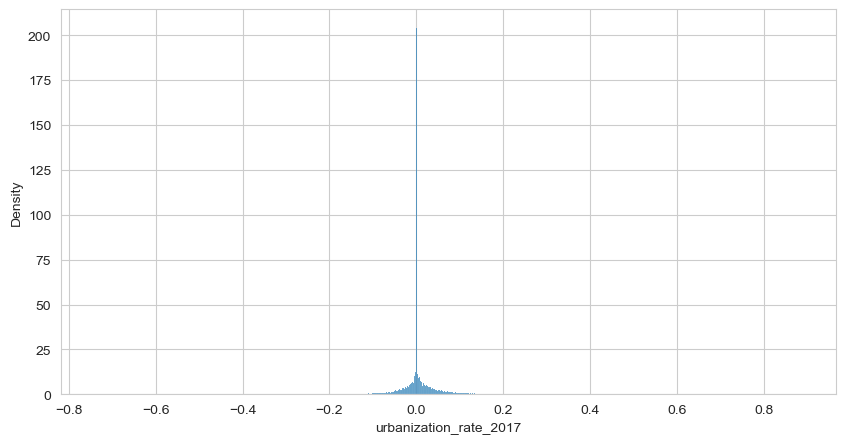

In [129]:
# plot histogram for 2017 urbanization_rate_2017 with seaborn beautiful
# plt.figure(figsize=(10, 5))
# sns.histplot(dcc["urbanization_rate_2017"], bins=100)

# frequency?
plt.figure(figsize=(10, 5))
sns.histplot(dcc["urbanization_rate_2017"], bins=1000, stat="density")

# set style
sns.set_style("whitegrid")
# x axis -0.4 to 0.4
# plt.xlim(-0.4, 0.4)

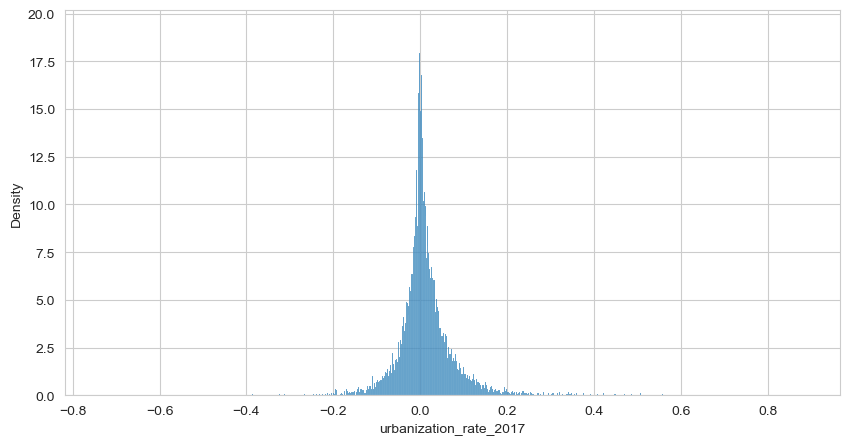

In [130]:
# plot histogram for 2017 urbanization_rate_2017 with seaborn beautiful
# plt.figure(figsize=(10, 5))
# sns.histplot(dcc["urbanization_rate_2017"], bins=100)

# frequency?
plt.figure(figsize=(10, 5))
sns.histplot(dcc[dcc.urbanization_rate_2017 != 0]["urbanization_rate_2017"], bins=1000, stat="density")

# set style
sns.set_style("whitegrid")
# x axis -0.4 to 0.4
# plt.xlim(-0.4, 0.4)

In [136]:
print(len(dcc[dcc.urbanization_rate_2017 > 0]["urbanization_rate_2017"]))
print(len(dcc[dcc.urbanization_rate_2017 < 0]["urbanization_rate_2017"]))

print(dcc[dcc.urbanization_rate_2017 > 0]["urbanization_rate_2017"].mean())
print(dcc[dcc.urbanization_rate_2017 < 0]["urbanization_rate_2017"].mean())


8676
6793
0.05034421125847643
-0.03551280017504215


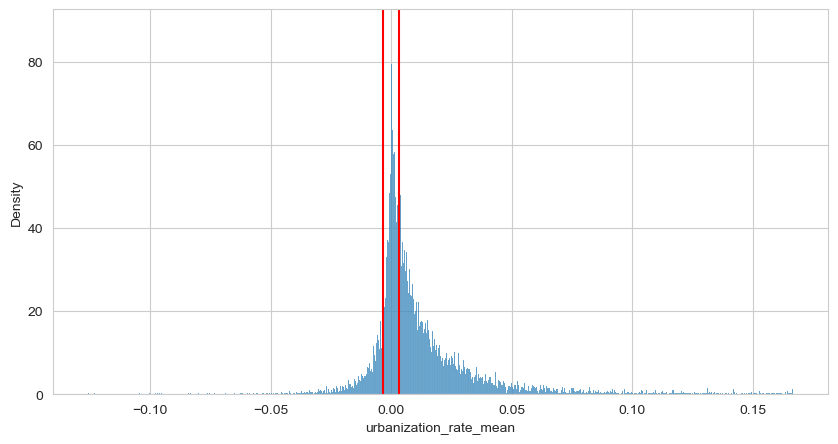

In [148]:
# Compute mean urbanization over all the years
dcc["urbanization_rate_mean"] = dcc[[f"urbanization_rate_{year}" for year in [2017, 2018, 2019, 2020, 2021, 2022]]].mean(axis=1)

# plot same graph as before
plt.figure(figsize=(10, 5))
sns.histplot(dcc[dcc.urbanization_rate_mean != 0]["urbanization_rate_mean"], bins=1000, stat="density")

# plot red vertical lines at -0.01 and 0.01
plt.axvline(x=-0.0034259259259259247, color="red")
plt.axvline(x=0.0034259259259259247, color="red")

In [144]:
print(len(dcc[dcc.urbanization_rate_mean > 0]["urbanization_rate_mean"]))
print(len(dcc[dcc.urbanization_rate_mean < 0]["urbanization_rate_mean"]))

print(dcc[dcc.urbanization_rate_mean > 0]["urbanization_rate_mean"].median())
print(dcc[dcc.urbanization_rate_mean < 0]["urbanization_rate_mean"].median())

12218
3801
0.00983062330623306
-0.0034259259259259247


In [143]:
0.007189880703108929 / 0.01918753379518609

0.3747162496158198

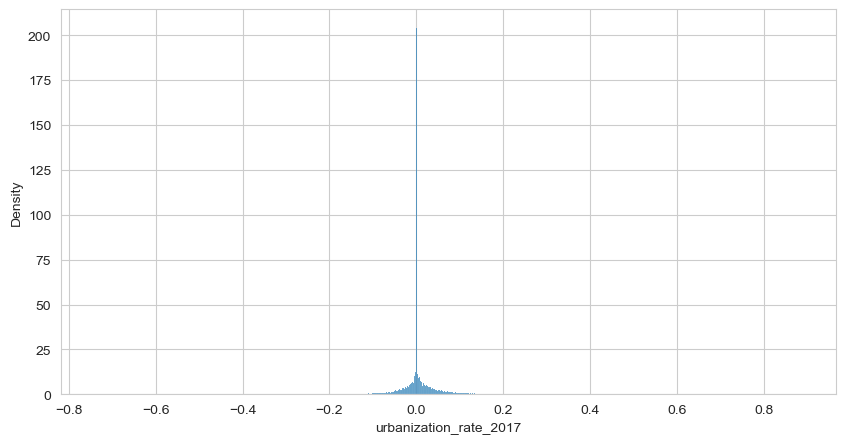

In [ ]:
# plot histogram for 2017 urbanization_rate_2017 with seaborn beautiful
# plt.figure(figsize=(10, 5))
# sns.histplot(dcc["urbanization_rate_2017"], bins=100)

# frequency?
plt.figure(figsize=(10, 5))
sns.histplot(dcc["urbanization_rate_2017"], bins=1000, stat="density")

# set style
sns.set_style("whitegrid")
# x axis -0.4 to 0.4
# plt.xlim(-0.4, 0.4)

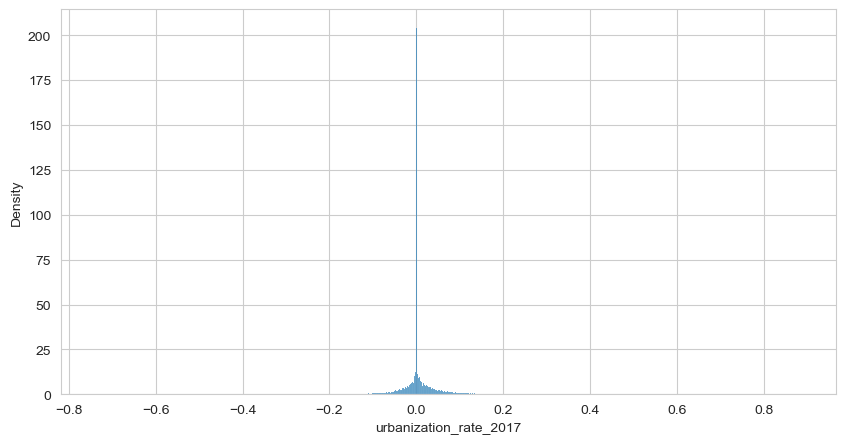

In [ ]:
# plot histogram for 2017 urbanization_rate_2017 with seaborn beautiful
# plt.figure(figsize=(10, 5))
# sns.histplot(dcc["urbanization_rate_2017"], bins=100)

# frequency?
plt.figure(figsize=(10, 5))
sns.histplot(dcc["urbanization_rate_2017"], bins=1000, stat="density")

# set style
sns.set_style("whitegrid")
# x axis -0.4 to 0.4
# plt.xlim(-0.4, 0.4)

### `Baseline 3`

Let's train an LSTM model taking 4 points as input and predicting the 5th.

In [48]:
x_train_1 = tensor[0:4, :, :, 0].reshape(-1, 4)
y_train_1 = tensor[4, :, :, 0].reshape(-1)
x_train_2 = tensor[1:5, :, :, 0].reshape(-1,4)
y_train_2 = tensor[5, :, :, 0].reshape(-1)
x_train = np.concatenate((x_train_1, x_train_2), axis=0)
y_train = np.concatenate((y_train_1, y_train_2), axis=0)

In [58]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Assuming you have your dataset ready, where each data point contains 4 input points and 1 output point
# X_train.shape should be (num_samples, 4, num_features) and y_train.shape should be (num_samples, 1, num_features)

# Define the number of LSTM units in the hidden layer
num_units = 512

# Define the input shape
input_shape = (4, 1)

# Create the LSTM model
model = Sequential()
model.add(LSTM(num_units, input_shape=input_shape))
model.add(Dense(1))  # Output layer with the same number of features as the input

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=512)

Epoch 1/50
89/89 [==============================] - 6s 60ms/step - loss: 0.1795 - val_loss: 0.1408
Epoch 2/50
89/89 [==============================] - 5s 58ms/step - loss: 0.1629 - val_loss: 0.1430
Epoch 3/50
16/89 [====>.........................] - ETA: 3s - loss: 0.1623

KeyboardInterrupt: 

In [59]:
x_train.shape

(45162, 4)

In [61]:
sample = pd.DataFrame(x_train).sample(100)

fig, ax  = plt.subplots(1, 4, figsize=(20, 5)) # 25 plots on each plot

,0,1,2,3
7242,0.728889,0.463333,0.012222,0.052222
29003,0.136043,0.230352,0.000000,0.000000
28783,1.000000,1.000000,1.000000,0.991111
15778,0.000000,0.353930,0.300813,0.272087
30932,0.054743,0.000000,0.000000,0.003794
...,...,...,...,...
4392,0.000000,0.000000,0.000000,0.000000
39779,0.695393,1.000000,0.501897,0.060976
44205,0.010556,0.000000,0.000000,0.000000
25605,1.000000,0.996667,1.000000,0.838333
